In [2]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import pandas as pd
import emcee

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import scipy.optimize as opt

import george
from george.kernels import ExpSquaredKernel, ConstantKernel, Matern32Kernel

In [4]:
DATALC_PATH = "/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr/"
DATAMAIN_PATH= "/Users/mariavincenzi/PhD/pycoco_2/data/"

#OUTPUT
# - fitted_photometry
#  for each object (1) Table with fitted photometry @spctra MJD
#                  (2) high cadence fitted photometry 
#                  (3) plot of the fit in each band

mm_cob56 = 1./77.
mm_ni56 = 1./6.


In [5]:
info_objects = np.genfromtxt(DATAMAIN_PATH+'info/info.dat', dtype=None, names=True, encoding='utf-8')
name_type = dict(zip(info_objects['snname'], info_objects['Type']))

In [6]:
name_type.keys()

dict_keys(['SN2006bp', 'SN2009iz', 'SN2004gv', 'SN2013fs', 'SN2013by', 'SN2006el', 'SN2008bo', 'SN2004aw', 'SN2007ru', 'SN2012A', 'SN2011bm', 'SN2009bw', 'SN2007Y', 'SN2011ei', 'ASASSN15no', 'SN2004A', 'SN2009E', 'SN2006jc', 'SN2008aq', 'iPTF13bvn', 'SN2005db', 'SN2013ej', 'SN2010al', 'SN2004gt', 'SN2009ip', 'SN2005bf', 'SN1998A', 'SN2007od', 'SN2009jf', 'SN2009ib', 'SN1994I', 'SN2004et', 'SN2013ge', 'SN2013am', 'SN2017eaw', 'SN2007gr', 'SN2012ec', 'SN2002ap', 'SN2005hg', 'SN2011fe', 'SN2000eo', 'SN2013ab', 'SN2016bkv', 'SN2011ht', 'SN2009dd', 'SN2012au', 'SN2009er', 'SN2014G', 'SN1998S', 'SN2012aw', 'SN2016gkg', 'SN2008D', 'SN2013df', 'SN2013hj', 'SN2003jd', 'SN2016X', 'SN2004gq', 'SN2002gd', 'SN2007C', 'SN1996cb', 'SN2005cp', 'SN2011fu', 'SN2009kr', 'SN2006V', 'SN2008bj', 'SN2011hs', 'ASASSN15oz', 'SN1987A', 'SN2000cb', 'SN2004fe', 'SN2006ep', 'SN2005cs', 'SN1999em', 'SN1993J', 'SN2009N', 'SN1999dn', 'SN1998bw', 'ASASSN14jb', 'SN2011dh', 'SN2007uy', 'SN2008in', 'SN2008ax', 'SN2009mg'

In [7]:
color_dict = {'A':'grey',
              'BessellU': 'blue',
              'BessellB': 'royalblue',
                'BessellV':  'limegreen',
                'BessellR':  'red',
                'BessellI':  'mediumvioletred',
                'SDSS_g':    'darkgreen',
                'SDSS_i':    'purple',
                'SDSS_r':    'darkred',
                'SDSS_z':    'sienna',
                'SDSS_u': 'darkblue',
                'swift_UVW1':'grey',
                'swift_UVW2':'grey',
                'swift_UVM2':'grey',
                'swift_U':'grey',
                'swift_V':'grey',
                'swift_B':'grey'}

color_dict = {'A':'grey',
              'Bessell_U': 'blue',
              'Bessell_B': 'royalblue',
                'Bessell_V':  'limegreen',
                'Bessell_R':  'red',
                'Bessell_I':  'mediumvioletred',
                'sdss_g':    'darkgreen','ptf_g':    'darkgreen', "sdss_g'":    'darkgreen',
                'sdss_i':    'indianred', "sdss_i'":    'indianred',
                'sdss_r':    'darkred', "sdss_r'":    'darkred',
                'sdss_z':    'sienna', "sdss_z'":    'sienna',
                'sdss_u': 'darkblue', "sdss_u'": 'darkblue',
                'Y':  'salmon','H':  'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown',
                'swift_UVW1':'indigo',
                'swift_UVW2':'darkblue',
                'swift_UVM2':'darkmagenta',
                'swift_U':'plum',
                'swift_V':'teal',
                'swift_B':'powderblue'}

exclude_filt = ['H', 'J', 'K', 'Ks','KS', 'Y']

In [8]:
def err_to_log10(flux, err_flux):
    flux=np.array(flux, dtype=float)
    err_flux=np.array(err_flux, dtype=float)
    return 1./np.log(10.) * err_flux/flux

def err_from_log10(logflux, logerr_flux):
    return np.log(10.) * 10**logflux * logerr_flux

## linear regression from x,y independent errors
def lin_regr_weigthed(x,y,w):
    
    Delta = sum(w)*sum(w*x**2) - (sum(w*x))**2
    A = ( sum(w*x**2)*sum(w*y) - sum(w*x)*sum(w*y*x) )/(Delta)
    B = ( sum(w)*sum(w*y*x) - sum(w*x)*sum(w*y) )/(Delta)
    print (A,B)
    sigma_A = np.sqrt( sum(w*x**2)/Delta )
    sigma_B = np.sqrt( sum(w)/Delta )
    print (sigma_A,sigma_B)

    return (A,B,sigma_A,sigma_B)

def lin_regr_weigthed_fixm(x,y,w):
    
    Delta = sum(w)*sum(w*x**2) - (sum(w*x))**2
    A = ( sum(w*x**2)*sum(w*y) - sum(w*x)*sum(w*y*x) )/(Delta)
    B = ( sum(w)*sum(w*y*x) - sum(w*x)*sum(w*y) )/(Delta)
    print (A,B)
    sigma_A = np.sqrt( sum(w*x**2)/Delta )
    sigma_B = np.sqrt( sum(w)/Delta )
    print (sigma_A,sigma_B)

    return (A,B,sigma_A,sigma_B)

In [9]:
def lin_regr_weigthed(newx,x,y,err):
    def fit(xx,m,q):
        return q+m*xx
    R,cov = opt.curve_fit(fit, x, y, p0=[mm_cob56,3.],
                        sigma=err, maxfev=10000)
    rand = np.random.multivariate_normal(R, cov, size=1000)
    fit_ = fit(newx, *R)
    fit_err = pd.DataFrame(fit(newx, *par) for par in rand).std().values
    return (fit_,fit_err,R[0],R[1])

def lin_regr_weigthed_fixm(newx,x,y,err, force_mm=mm_cob56):
    def fit(xx,q):
        return q+force_mm*xx
    R,cov = opt.curve_fit(fit, x, y,
                        sigma=err, maxfev=10000)
    if np.any(np.isinf(cov))|np.any(np.isnan(cov)):
        fit_ = fit(newx, *R)
        fit_err = max(err)
    else:
        rand = np.random.multivariate_normal(R, cov, size=1000)
        fit_ = fit(newx, *R)
        fit_err = pd.DataFrame(fit(newx, *par) for par in rand).std().values
    return (fit_,fit_err,R[0])



In [972]:

class SNPhotometryClass():
    """Class with photometry for each object:
            - load the photometry from the DATA folder
            - get the phootmetry in each filter
            - plot the raw photometry 
            - fit the photometry using GP
    """
    
    def __init__(self, main_path, lc_path, snname, verbose=False):
        """
        """

        ## Initialise the class variables
        self.main_path = main_path
        self.lc_data_path = lc_path+'/'
        #self.lc_data_path = '/Users/mariavincenzi/PhD/pycoco_2/data/lc/'

        self.spec_data_path = main_path+'/spec/'
        self.snname = snname   
        self.set_data_directory(verbose)

    def set_data_directory(self, verbose):
        """
        Set a new data directory path.
        Enables the data directory to be changed by the user.
        """
        SNphotometry_PATH = os.path.join(self.lc_data_path, '%s.dat'%self.snname)
        
        try:
            if verbose: print('Looking for Photometry for %s in%s'%(self.snname, SNphotometry_PATH))
            if os.path.isfile(SNphotometry_PATH):
                if verbose: print ('Got it!')
                self.sn_rawphot_file = SNphotometry_PATH
                pass
            else:
                if not os.path.isdir(self.lc_data_path):
                    print ('I cant find the directory with photometry. Check %s'%self.lc_data_path)
                    pass
                else: 
                    print ('I cant find the file with photometry. Check %s'%SNphotometry_PATH)
                    pass
    
        except Exception as e:
            print (e)

    def load(self, verbose = False):
        """
        Loads a single photometry file.
        with ('MJD', 'flux', 'flux_err', 'filter')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        if verbose: print('Loading %s'%self.sn_rawphot_file)
        try:
            lc_file = np.genfromtxt(self.sn_rawphot_file,
                                    names=['MJD','filter','flux','flux_err','FilterSet'], 
                                    usecols=[0,1,2,3,4], 
                                    dtype=None,encoding="utf-8")

            mask_filt = np.array([f not in exclude_filt for f in lc_file['filter']])
            lc_no_badfilters = lc_file[mask_filt]
            mask_filt = np.array([~np.isnan(f) for f in lc_no_badfilters['flux']])
            self.phot = lc_no_badfilters[mask_filt]
            
            #filtname_filtset = [fn+'__'+fs for fn,fs in zip(self.phot['filter'], self.phot['FilterSet'])]
            self.avail_filters = np.unique(self.phot['filter'])

            self.phot_extended = self.phot
            print ('Photometry loaded')

            
        except Exception as e:
            print (e)
            print ('Are you sure you gave me the right format? Check documentation in case.')

    def get_availfilter(self, verbose = False):
        """
        get available filter for this SN
        """
        #if photometry is not already loaded, load it!
        if (not hasattr(self, "phot"))|(not hasattr(self, "avail_filters")):
            self.load()
        return self.avail_filters
        
    def get_singlefilter(self, single_filter, extended_clipped = False, verbose = False):
        """
        Loads from photometry file just 1 filter photometry.
        with ('MJD', 'flux', 'flux_err', 'filter')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()

        if not (isinstance(single_filter, str)):
            print ('Single filter string please')
            return None
        
        if single_filter not in self.avail_filters:
            print ('Looks like the filter you are looking for is not available')
            return None
        
        if extended_clipped:
            if not hasattr(self, "phot_extended"):
                self.extend_photometry()
            filt_index = self.phot_extended['filter']==single_filter
            return self.phot_extended[filt_index] 
        else: 
            filt_index = self.phot['filter']==single_filter
            return self.phot[filt_index]
        
    
    def get_mjdpeak(self, verbose = False):
        """
        Loads from photometry for each filter, measure peak for each filter
        get a rough estimate of the paek_mjd
        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
            
        mjd_peaks_list=[]
        for f in self.avail_filters:
            phot_perfilt = self.get_singlefilter(f)
            mjd_peak = phot_perfilt['MJD'][np.argmax(phot_perfilt['flux'])]
            mjd_peaks_list.append(mjd_peak)
            
        return np.min(mjd_peaks_list)
    
    def extend_photometry(self, before_peak=30., after_peak=500., verbose = False):
        """
        Extend photometry in every filter        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()

        if not hasattr(self, "clipped_phot"):
            self.clip_photometry()
        
        mjd_peak = self.get_mjdpeak()
        LC = self.clipped_phot
        
        filt_avail = self.avail_filters

        mjd_ext_early = min((mjd_peak - before_peak), min(LC['MJD']))
        before_peak = mjd_peak - mjd_ext_early -5.

        mjd_ext_latly = (mjd_peak + after_peak)
        
        LC_extended = LC
        
        for filt in filt_avail:
            LC_xfilter = LC[LC['filter']==filt]

        self.phot_extended = self.clipped_phot
        return self.clipped_phot

    def plot_raw_phot(self, filt_list=None, plt_extended_clipped=False, save_fig=False, \
                      save_format='png', output_path_name=None):
        
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        if (plt_extended_clipped)&(not hasattr(self, "phot_extended")):
            self.extend_photometry()

        if filt_list:
            filt_toplot = filt_list
        else:
            filt_toplot = self.avail_filters
        fig = plt.figure(1)
        for f in filt_toplot:
            phot_f = self.get_singlefilter(f, extended_clipped=plt_extended_clipped)
            plt.errorbar(phot_f['MJD'], phot_f['flux'], phot_f['flux_err'],\
                         marker='.', linestyle='None', label=f)
        plt.legend(loc='best')
        plt.show()
        if save_fig:
            if output_path_name:
                fig.savefig(output_path_name)
            else:
                fig.savefig(self.sn_rawphot_file.replace('.dat', '_raw_photo.%s'%save_format))
        return None

    def plot_GP_fit_phot(self, filt_list=None, save_fig=False, save_format='png', output_path_name=None):
        
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        
        if not hasattr(self, "gp"):
            self.load()

        if filt_list:
            filt_toplot = filt_list
        else:
            filt_toplot = self.avail_filters
        fig = plt.figure(1)
        for f in filt_toplot:
            phot_f = self.get_singlefilter(f)
            plt.errorbar(phot_f['MJD'], phot_f['flux'], yerr=phot_f['flux_err'],\
                         marker='.', linestyle='None', label=f)
        plt.legend(loc='best')
        plt.show()
        if save_fig:
            if output_path_name:
                fig.savefig(output_path_name)
            else:
                fig.savefig(self.sn_rawphot_file.replace('.dat', '_raw_photo.%s'%save_format))
        return None



    def clip_LC_filter(self, filter_name, clipping_mjd_delta = 0.5):
        
        def clip_one_point(mjd_unclipped, flux_unclipped, fluxerr_unclipped, instr_unclipped, clipping_index):
            mjd_tbc = np.array([mjd_unclipped[clipping_index], mjd_unclipped[clipping_index+1]])
            flux_tbc = np.array([flux_unclipped[clipping_index], flux_unclipped[clipping_index+1]])
            flux_err_tbc = np.array([fluxerr_unclipped[clipping_index], fluxerr_unclipped[clipping_index+1]])
            mjd_avg = np.average(mjd_tbc)
            flux_avg, sum_w = np.average(flux_tbc, weights= 1./(flux_err_tbc)**2, returned=True)
            flux_err_avg = max([np.std(flux_tbc), np.sqrt(1./sum_w)])
            clipped_mjd_sorted = np.delete(mjd_unclipped, clipping_index)
            clipped_flux_sorted = np.delete(flux_unclipped, clipping_index)
            clipped_flux_err_sorted = np.delete(fluxerr_unclipped, clipping_index)
            clipped_instr_sorted = np.delete(instr_unclipped, clipping_index)
            clipped_mjd_sorted[clipping_index] = mjd_avg
            clipped_flux_sorted[clipping_index] = flux_avg
            clipped_flux_err_sorted[clipping_index] = flux_err_avg
            #print ('I clipped index:', clipping_index, ' Lenght was %i, now is %i '%(len(mjd_unclipped), len(clipped_mjd_sorted)))
            return clipped_mjd_sorted, clipped_flux_sorted, clipped_flux_err_sorted, clipped_instr_sorted
    
        LC_filt = self.get_singlefilter(filter_name)
        mjd_sorted = np.sort(LC_filt['MJD'])
        flux_sorted = LC_filt['flux'][np.argsort(LC_filt['MJD'])]
        flux_err_sorted = LC_filt['flux_err'][np.argsort(LC_filt['MJD'])]
        instr_sorted = LC_filt['FilterSet'][np.argsort(LC_filt['MJD'])]

        new_mjd_sorted = np.array([round(m,2) for m in mjd_sorted]) 
        double = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)
        new_flux_sorted = np.copy(flux_sorted)
        new_flux_err_sorted = np.copy(flux_err_sorted)
        new_Instr_sorted = np.copy(instr_sorted)
        
        while len(np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0])>=1:
            tbc_indexes = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0]
            ind = tbc_indexes[0]
            R = clip_one_point(new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_Instr_sorted, ind)
            new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_Instr_sorted= R
        new_filter_sorted = np.full(len(new_mjd_sorted), filter_name, dtype='|S20')
        new_LC=[]
        for i in zip(new_mjd_sorted, new_filter_sorted, new_flux_sorted, new_flux_err_sorted, new_Instr_sorted):
            new_LC.append(i)
        new_LC = np.array(new_LC, LC_filt.dtype)
        
        print (filter_name, 'Before clipping %i, after %i'%(len(mjd_sorted), len(new_LC)))
        return new_LC
    
    def clip_photometry(self, verbose = False):
        """
        Extend photometry in every filter        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        
        filt_avail = self.avail_filters
        
        clipping_mjd_delta = 0.2
        LC_clipped = np.array([], self.phot.dtype) 
        for ff in filt_avail:
            LC_xfilter = self.clip_LC_filter(ff, clipping_mjd_delta)
            LC_clipped = np.concatenate([LC_clipped, LC_xfilter])
        self.clipped_phot = LC_clipped
        return None
    
    def get_spec_mjd(self, verbose=False):
        phase_list_file = self.main_path + 'spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None, encoding="utf-8")
            return parse_phase['f0']
        except: 
            #print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            raise Exception(' !!!!!!!!!!!!! \n I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
        
    def get_spec_list(self, verbose=False):
        phase_list_file = self.main_path + 'spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None,encoding="utf-8")
            return parse_phase['f2']
        except: 
            print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
        
    def get_noise_level(self):
        if not hasattr(self, "avail_filters"):
            self.load()
        default_wn_noise_dict = dict(zip(self.avail_filters, np.array(['10e-5' for i in self.avail_filters])))
        white_noise_file = np.genfromtxt(self.lc_data_path+'white_noise_level_file.dat',\
                                         comments='#', names=True, dtype=None, encoding="utf-8")
        if self.snname not in white_noise_file['snname']:
            return default_wn_noise_dict
        else:
            tuned_values = white_noise_file[white_noise_file['snname']==self.snname]
            wn_noise_dict = dict(zip(tuned_values['filt'], (tuned_values['noise'])))
            return wn_noise_dict
    
    def get_anchoring(self, filt):
        if not hasattr(self, "avail_filters"):
            self.load()
        default_anchor_before = 'n'
        default_anchor_after = 'n'

        anchoring_file = np.genfromtxt(self.lc_data_path+'white_noise_level_file.dat',\
                                         comments='#', names=True, dtype=None, encoding="utf-8")
        if self.snname not in anchoring_file['snname']:
            return default_anchor_before, default_anchor_after
        else:
            tuned_values = anchoring_file[(anchoring_file['snname']==self.snname)&(anchoring_file['filt']==filt)]
            return tuned_values['anchor_before'], tuned_values['anchor_after']
        
    def LC_extend_xfilter(self, filt, minMJD=None, maxMJD=None):
        LC_filt_extended = self.get_singlefilter(filt, extended_clipped=True)


        mjd_unsorted = LC_filt_extended['MJD']
        mjd = np.sort(mjd_unsorted)
        orig_flux = LC_filt_extended['flux'][np.argsort(mjd_unsorted)]
        orig_flux_err = LC_filt_extended['flux_err'][np.argsort(mjd_unsorted)]

        ## norm time
        offset_time = mjd[np.argmax(orig_flux)]#min(mjd)#
        t = mjd - offset_time
        t_spectra = self.get_spec_mjd() - offset_time
        ## norm flux
        max_fl = max(orig_flux)
        logf = -np.log(orig_flux/max_fl)
        logferr = orig_flux_err/orig_flux

        mask_lenght = dict_phase_tail[self.snname][filt]
        mask_tail = t>mask_lenght
        t_lr = t[mask_tail]
        logf_lr = logf[mask_tail]
        logferr_lr = logferr[mask_tail]
        w_lr = 1./logferr_lr**2
        
        fig = plt.figure(figsize=(22,4))
        plt.subplot(141)
        plt.errorbar(t, logf, yerr=logferr, marker='.', 
                     mfc='grey', mec='grey', color='grey', linestyle='None')
        
        plt.errorbar(t_lr, logf_lr, yerr=logferr_lr,marker='.', 
                     mfc='k', mec='k', color='k', linestyle='None')
        plt.title(self.snname+'  '+filt)

        #max_phase = ?
        mjd_last_spec = max(t_spectra)
        mjd_last_phot_point = max(t_lr)
        #end_lc = max(mjd_last_spec, 200)
        end_lc = min( max(mjd_last_phot_point, 200), 250)

        print (filt, mjd_last_phot_point)
        if self.snname in ['SN1998bw', 'SN2005bf', 'SN2006aa', 'SN2006aj',
                          'SN2007Y', 'SN2008fq', 'SN2005hg', 'SN2006T','SN2014G',
                           'SN2010al', 'SN2012ap', 'SN2013fs', 'SN2013ge']:
            max_phase = mjd_last_phot_point + 30
        elif (mjd_last_phot_point +100) < end_lc:
            max_phase = mjd_last_phot_point + 100
        else:
            max_phase = end_lc

        #min(max(max(t_spectra)+20,  max(t_lr)+100),230)
        
        new_t = np.arange(min(t_lr), max_phase,1.)
        if (self.snname in delay):
            new_t = np.arange(min(t_lr)+10., max_phase,1.)
        if (self.snname in anticipate)&(filt not in ['sdss_u', 'Bessell_U', 'swift_U','swift_UVW1','swift_UVW2','swift_UVM2']):
            new_t = np.arange(110., max_phase,1.)
        if self.snname=='SN2013am':new_t = np.arange(min(t_lr)-110., max_phase,1.)
        if self.snname=='ASASSN15oz':
            if filt =='swift_UVM2': new_t = np.arange(min(t_lr), min(t_lr)+60.,1.)
        if self.snname=='ASASSN14jb':
            if filt =='swift_U': new_t = np.arange(min(t_lr), min(t_lr)+15.,3.)
        if self.snname=='SN2013fs':
            if filt in ('Bessell_V', 'Bessell_B'): new_t = np.arange(min(t_lr)-10., max_phase,1.)
        #if self.snname=='SN2005bf':
        #    if filt in ['sdss_i', 'sdss_r']: new_t = np.arange(min(t_lr)-5., max_phase,1.)

        if (self.snname in short_U_ext)&(filt in ['sdss_u', 'Bessell_U', 'swift_U',"sdss_u'",
                                                  'swift_UVW1','swift_UVW2','swift_UVM2']):
            new_t = np.arange(min(t_lr)+0., min(t_lr)+100.,2.)

        #new_t = np.arange(150., max_phase,1.)

        force_mm_fit= False
        if len(logf_lr)<=4: force_mm_fit=True
        if self.snname in dict_fix_slope.keys():
            if filt in dict_fix_slope[self.snname]:
                force_mm_fit=True

        
        if force_mm_fit:
            print ('fix cobalt')
            fix_cobalt = True
            plt.subplot(142)
            plt.errorbar(t_lr, logf_lr, yerr=logferr_lr,marker='.', 
                         mfc='k', mec='k', color='k', linestyle='None')
            
            #qq, mm, sigma_qq, sigma_mm  = lin_regr_weigthed_fixm(t_lr, logf_lr,w_lr)
            #fit_mag=mm*new_t+qq
            #err_prop_func = lambda x: ( (x*sigma_mm)**2 + sigma_qq**2 )**0.5  
            #fit_mag_err = err_prop_func(new_t)
            mm = mm_cob56
            if self.snname in dict_fix_slope.keys():
                if filt in dict_fix_slope[self.snname]:
                    mm_fix = dict_fix_slope[self.snname][filt]
                    mm = mm_fix
            fit_mag, fit_mag_err, qq = lin_regr_weigthed_fixm(new_t, t_lr, logf_lr, logferr_lr, force_mm=mm)

            plt.text(min(new_t),max(fit_mag), '%.3f'%mm, fontsize=20)
            plt.plot(new_t, fit_mag, '.', color="#4682b4", alpha=1)            
            plt.fill_between(new_t, fit_mag - fit_mag_err,
                              fit_mag + fit_mag_err, color="#4682b4", alpha=0.3)
            
            plt.plot(new_t, mm_cob56*(new_t)+qq, "^g", alpha=0.5)
            #plt.plot(new_t, mm_ni56*(new_t)+qq, "g--", alpha=0.5)
            plt.title(self.snname+'  '+filt)
        
        else:
            fix_cobalt = False
            plt.subplot(142)
            plt.errorbar(t_lr, logf_lr, yerr=logferr_lr,marker='.', 
                         mfc='k', mec='k', color='k', linestyle='None')
            
            #qq, mm, sigma_qq, sigma_mm = lin_regr_weigthed(t_lr, logf_lr,w_lr)
            #fit_mag=mm*new_t+qq
            #err_prop_func = lambda x: ( (x*sigma_mm)**2 + sigma_qq**2 )**0.5  
            #fit_mag_err = err_prop_func(new_t)

            fit_mag, fit_mag_err, mm, qq = lin_regr_weigthed(new_t, t_lr, logf_lr, logferr_lr)

            plt.text(min(new_t),max(fit_mag), '%.3f'%mm, fontsize=20)
            plt.plot(new_t, fit_mag, '.', color="#4682b4", alpha=1)            
            plt.fill_between(new_t, fit_mag - fit_mag_err,
                              fit_mag + fit_mag_err, color="#4682b4", alpha=0.3)
            
            plt.plot(new_t, mm_cob56*(new_t)+qq, "^g", alpha=0.5)
            #plt.plot(new_t, mm_ni56*(new_t)+qq, "g--", alpha=0.5)
            plt.title(self.snname+'  '+filt)
            #
        
        if (mm<mm_cob56)&(name_type[self.snname] not in ['IIP','IIL','II'])&(~fix_cobalt):
            plt.subplot(143)
            plt.errorbar(t_lr, logf_lr-mm_cob56*t_lr, yerr=logferr_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')
            avg, inv_err = np.average(logf_lr-mm_cob56*t_lr, weights=1/(logferr_lr**2), returned=True)
            sigma_qq = np.std(logf_lr-mm_cob56*t_lr)
            plt.hlines(avg, min(t_lr), max(t_lr), 'r')
            plt.fill_between(new_t,  avg-sigma_qq,
                          avg+sigma_qq, color="r", alpha=0.2)
            mm=mm_cob56
            qq= avg


        fit = max_fl * np.exp(-(fit_mag))
        fit_err = np.abs(fit * fit_mag_err)
        
        #plt.errorbar(t, orig_flux, yerr=orig_flux_err, marker='.', 
        #             mfc='grey', mec='grey', color='grey', linestyle='None')
        plt.subplot(144)
        plt.errorbar(t_lr, orig_flux[mask_tail], yerr=orig_flux_err[mask_tail], marker='.', 
                     mfc='k', mec='k', color='k', linestyle='None')

        plt.errorbar(new_t, fit, yerr=fit_err, marker='.', 
                     mfc='white', mec='r', color='r', linestyle='None')
        plt.title(self.snname+'  '+filt)
        plt.show()
        return (new_t+offset_time, fit, fit_err)


    def save_plot_GPfit(self, save_fig_output=None):
        if not hasattr(self, "results_mainpath"):
            self.create_results_folder()

        if not hasattr(self, "fitted_phot"):
            self.LCfit_withGP()
        else:
            print ("""LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.""")


        max_flux = [10**-20]
        fig = plt.figure(figsize=(20,5))
        for f in self.avail_filters:
            c = color_dict[f]
            mjd, flux, err_flux = self.fitted_phot[f]['clipped_extended_data'] 
            new_mjd, mu, std= self.fitted_phot[f]['fit_highcadence'] 

            a=plt.errorbar(mjd, flux, yerr=err_flux, fmt='.', mfc= c, \
                       elinewidth=0.8, color= c,linestyle='None')
            plt.plot(new_mjd, mu, color=a[0].get_color(), label=f)
            plt.fill_between(new_mjd, (mu+std), (mu-std), color=a[0].get_color(), alpha=0.1)
            max_flux.append(max(flux))
        
        plt.hlines(0, min(new_mjd)-7., max(new_mjd))
        plt.vlines(self.get_spec_mjd(), 10**-20, max(max_flux), lw=0.8, linestyle=':', color='k', label='Spectra')
        try:
            plt.xlim(min(self.phot_extended['MJD'])-7., max(self.phot_extended['MJD'])+30.)
        except:
            plt.xlim(min(self.phot_extended['MJD'])-7., max(self.phot_extended['MJD'])+30.)

        plt.legend(fontsize=11, loc='best', fancybox=True, framealpha=0.5)
        plt.title(self.snname+'  '+filt)
        if save_fig_output is None:
            fig.savefig(self.results_mainpath+'fittedGP_%s_.pdf'%self.snname, bbox_inches='tight')
        else:
            fig.savefig(save_fig_output, bbox_inches='tight')
        return None
    

    def create_extended_LC(self, name_file = None):
        lc_file = pd.DataFrame(np.genfromtxt(self.sn_rawphot_file,
                               names=['MJD','band','Flux','Flux_err','FilterSet', 'Source'], 
                               usecols=[0,1,2,3,4,5], 
                               dtype=None,encoding="utf-8"))
        
        for ff in dict_phase_tail[self.snname]:
            print (ff)
            extr_pts_pd = pd.DataFrame().reindex_like(lc_file)[:0]
            
            mjd_new, fit, fit_err = self.LC_extend_xfilter(ff)
            extr_pts_pd['MJD'] = mjd_new
            extr_pts_pd['band'] = np.full(len(mjd_new), fill_value=ff)
            extr_pts_pd['Flux'] = fit
            extr_pts_pd['Flux_err'] = fit_err
            extr_pts_pd['FilterSet'] = np.full(len(mjd_new), fill_value='SUDO_PTS')
            extr_pts_pd['Source'] = np.full(len(mjd_new), fill_value='SUDO_PTS')
            lc_file = lc_file.append(extr_pts_pd)
        return lc_file
    

In [992]:
dict_fix_slope = {'SN1994I': {'Bessell_U': 0.17},'ASASSN14jb': {'swift_U': 0.03},
 'SN2004gt': {'Bessell_V': 0.018, 'sdss_g': 0.018, 'sdss_u': 0.018},
 'SN2005bf': {'Bessell_B': 0.036, 'sdss_g': 0.036,'sdss_i': 0.03,'sdss_r': 0.03,},#'
 'SN2005hg': {'Bessell_B': mm_cob56},
 'SN2006aj': {'Bessell_B': 0.062,'Bessell_V': 0.062,'swift_U': 0.062,'swift_V': 0.062},
 'SN2006ep': {'sdss_u': 0.035},
 'SN2008D': {'Bessell_B': 0.017, 'swift_U':0.05},
 'SN2008aq': {'sdss_u': 0.1},
 'SN2008bo': {'Bessell_B': 0.02, 'swift_U': 0.02},
 'SN2008in': {'Bessell_B': 0.009, 'swift_U': 0.05},
 'SN2009ib': {"sdss_u'": 0.08},
 'SN2009jf': {'Bessell_U': 0.016},
 'SN2011dh': {'Bessell_B': 0.018, 'Bessell_U': 0.018, "sdss_i'": 0.018},
 'SN2011ei': {'swift_B': mm_cob56, 'swift_U': 0.1},
 'SN2011hs': {'Bessell_I': 0.02, "sdss_u'": 0.014},
 'SN2012A': {'Bessell_I': 0.008},
 'SN2012au': {'Bessell_B': mm_cob56,'swift_U': 0.014,'swift_UVW1': 0.014},
 'SN2013am': {'Bessell_V': 0.005,},
 'SN2013by': {'Bessell_B': mm_cob56,'sdss_g': mm_cob56},
 'SN2013ge': {"sdss_r'": 0.015, 'swift_V': 0.015}}

In [993]:
short_U_ext = ['SN1994I', 'SN2005hg', 'SN2006ep', 'SN2008aq', 'SN2008bo', 'SN2009ib', 'SN2011ei', 'SN2012au']

In [994]:
dict_phase_tail = {'ASASSN14jb': {'Bessell_B': 100, 'Bessell_V': 100, 'swift_U': 18},
 'ASASSN15oz': {'Bessell_B': 80, 'Bessell_V': 80, 'sdss_g': 80, 'sdss_i': 80, 'sdss_r': 80, 
                'swift_U': 30, 'swift_UVW1': 30, 'swift_UVW2': 30,'swift_UVM2': 30},
 'SN1993J': {'Bessell_B': 75, 'Bessell_I': 55, 'Bessell_R': 55, 'Bessell_V': 55},
 'SN1994I': {'Bessell_B': 50, 'Bessell_I': 60, 'Bessell_R': 60, 'Bessell_U': 10, 'Bessell_V': 60},
 'SN1998bw': {'Bessell_B': 15, 'Bessell_V': 15},
 'SN1999dn': {'Bessell_B': 30, 'Bessell_R': 105, 'Bessell_V': 105},
 'SN1999em': {'Bessell_B': 100, 'Bessell_I': 50, 'Bessell_R': 50, 'Bessell_U': 60, 'Bessell_V': 100},
 'SN2002ap': {'Bessell_I': 25, 'Bessell_R': 30, 'Bessell_V': 30},
 'SN2004aw': {'Bessell_B': 45, 'Bessell_I': 45, 'Bessell_R': 45, 'Bessell_V': 45},
 'SN2004et': {'Bessell_U': 40},
 'SN2004fe': {'Bessell_B': 35, 'Bessell_V': 35, 'sdss_g': 35, 'sdss_i': 35, 'sdss_r': 35, 'sdss_u': 20},
 'SN2004gq': {'Bessell_B': 55, 'Bessell_V': 50, 'sdss_r': 50, 'sdss_u': 50},
 'SN2004gt': {'Bessell_B': 40, 'Bessell_V': 40, 'sdss_g': 35, 'sdss_r': 35, 'sdss_u': 20},
 'SN2004gv': {'Bessell_B': 25, 'Bessell_V': 25, 'sdss_i': 25, 'sdss_u': 15},
 'SN2005bf': {'Bessell_B': 35, 'Bessell_V': 40, 'sdss_i': 18,'sdss_r': 18,'sdss_g': 25, 'sdss_u': 15},
 'SN2005cs': {'Bessell_B': 125, 'Bessell_R': 60, 'Bessell_V': 135},
 'SN2005hg': {'Bessell_B': 25, 'Bessell_U': 10, 'Bessell_V': 50, "sdss_r'": 50},
 'SN2006T': {'Bessell_B': 80, 'Bessell_V': 80},
 'SN2006V': {'Bessell_V': 40, 'sdss_g': 40, 'sdss_i': 40, 'sdss_r': 40},
 'SN2006aa': {'Bessell_V': 45, "sdss_i'": 40, "sdss_r'": 40},
 'SN2006aj': {'Bessell_B': 10, 'Bessell_V': 10, "sdss_r'": 10, 'swift_U': 20, 'swift_V': 20},
 'SN2006ep': {'Bessell_B': 40, 'Bessell_V': 40, 'sdss_g': 40, 'sdss_i': 40, 'sdss_r': 40, 'sdss_u': 15},
 'SN2007Y': {'Bessell_B': 20, 'Bessell_V': 20, 'sdss_i': 20, 'sdss_r': 20, 'sdss_u': 10},
 'SN2007gr': {'Bessell_B': 80, 'Bessell_I': 80, 'Bessell_R': 80, 'Bessell_U': 80, 'Bessell_V': 80, "sdss_i'": 80, "sdss_r'": 80},
 'SN2007od': {'Bessell_B': 130, 'Bessell_I': 130, 'Bessell_R': 130, 'Bessell_V': 130},
 'SN2007pk': {'Bessell_B': 45, 'Bessell_V': 40, "sdss_i'": 50, "sdss_r'": 50, 'swift_U': 10},#'Bessell_R': 50,
 'SN2007ru': {'Bessell_B': 55, 'Bessell_I': 70, 'Bessell_R': 70, 'Bessell_V': 70},
 'SN2007uy': {'Bessell_B': 85, 'Bessell_V': 80, "sdss_i'": 80, "sdss_r'": 80},
 'SN2008D': {'Bessell_B': 40, 'Bessell_V': 40, "sdss_i'": 50, "sdss_r'": 50, 'swift_U': 30},
 'SN2008aq': {'Bessell_V': 70, 'sdss_g': 80, 'sdss_i': 70, 'sdss_r': 70, 'sdss_u': 10},
 'SN2008ax': {'Bessell_B': 50, 'Bessell_I': 90, 'Bessell_R': 90, 'Bessell_V': 90},
 'SN2008bj': {'Bessell_B': 100, 'Bessell_V': 100, "sdss_i'": 100, "sdss_r'": 100},
 'SN2008bo': {'Bessell_B': 40, 'Bessell_V': 40, "sdss_i'": 40, "sdss_r'": 40, 'swift_U': 10},
 'SN2008fq': {'Bessell_B': 45, 'Bessell_V': 45, "sdss_g'": 45, "sdss_i'": 45, "sdss_r'": 45, "sdss_u'": 35},
 'SN2008in': {'Bessell_B': 120, 'Bessell_V': 100, "sdss_i'": 75, "sdss_r'": 100, "swift_U": 15},
 'SN2009bb': {'Bessell_V': 30},
 'SN2009bw': {'Bessell_I': 140, 'Bessell_R': 140, 'Bessell_U': 40, 'Bessell_V': 140},
 'SN2009dd': {'Bessell_B': 110, 'Bessell_I': 90, 'Bessell_R': 130, 'Bessell_V': 120},
 'SN2009ib': {'Bessell_B': 135, 'Bessell_I': 85, 'Bessell_R': 135, 'Bessell_V': 135, "sdss_g'": 135, "sdss_u'": 15},
 'SN2009iz': {'Bessell_B': 30, 'Bessell_V': 60, "sdss_i'": 60, "sdss_r'": 60},
 'SN2009jf': {'Bessell_B': 65, 'Bessell_I': 65, 'Bessell_R': 65, 'Bessell_U': 45, 'Bessell_V': 65},
 'SN2010al': {'Bessell_B': 30, 'Bessell_V': 30, "sdss_i'": 25},
 'SN2011bm': {'Bessell_V': 65},
 'SN2011dh': {'Bessell_B': 75, 'Bessell_I': 35, 'Bessell_R': 35, 'Bessell_U': 55, 'Bessell_V': 35},#"sdss_i'": 35,
 'SN2011ei': {'Bessell_I': 15, 'Bessell_V': 20, 'swift_B': 17, 'swift_U': 12},
 'SN2011fu': {'Bessell_B': 100, 'Bessell_I': 50, 'Bessell_R': 50, 'Bessell_V': 50},
 'SN2011hs': {'Bessell_B': 25, 'Bessell_I': 20, 'Bessell_R': 25, 'Bessell_V': 25, "sdss_u'": 17},
 'SN2011ht': {'Bessell_I': 100, 'Bessell_R': 100, 'Bessell_V': 80},
 'SN2012A': {'Bessell_B': 100, 'Bessell_I': 80, 'Bessell_R': 100, 'Bessell_U': 40, 'Bessell_V': 100},
 'SN2012ap': {'Bessell_V': 25},
 'SN2012au': {'Bessell_B': 40, 'Bessell_I': 40, 'Bessell_R': 40, 'Bessell_V': 40, 'sdss_z': 40, 'swift_U': 20, 'swift_UVW1': 30},
 'SN2012aw': {'Bessell_B': 130, 'Bessell_I': 130, 'Bessell_R': 130, 'Bessell_U': 70, 'Bessell_V': 150, 'sdss_z': 120, 'swift_UVW1': 70},
 'SN2013ab': {'swift_U': 70, 'Bessell_B': 110, 'sdss_i': 110, 'sdss_r': 110, 'Bessell_V': 110,},
 'SN2013am': {'Bessell_I': 90, 'Bessell_R': 90, 'Bessell_V': 100},
 'SN2013by': {'Bessell_B': 90, 'Bessell_V': 80, 'sdss_g': 90, 'sdss_i': 80, 'sdss_r': 80, 'swift_UVW1': 25},
 'SN2013df': {'Bessell_B': 30, 'Bessell_I': 30, 'Bessell_R': 30, 'Bessell_V': 30},
 'SN2013ej': {'Bessell_B': 95, 'Bessell_I': 95, 'Bessell_R': 95, 'Bessell_V': 95},
 'SN2013fs': {'Bessell_B': 80, 'Bessell_I': 80, 'Bessell_R': 80, 'Bessell_V': 80, 'sdss_r': 80, 'swift_U': 15},
 'SN2013ge': {'Bessell_V': 40, "sdss_i'": 30, "sdss_r'": 30, 'swift_V': 30},
 'SN2014G': {'Bessell_B': 80, 'Bessell_U': 40, 'Bessell_V': 80},
 'SN2016X': {'Bessell_I': 90, 'Bessell_R': 90, 'Bessell_U': 40, 'Bessell_V': 90, 'sdss_i': 95},
 'SN2016bkv': {'Bessell_U': 32},
 'SN2016gkg': {'Bessell_B': 45, 'Bessell_I': 45, 'Bessell_R': 45, 'Bessell_V': 45, 'swift_U': 15},
 'iPTF13bvn': {'Bessell_I': 35, 'Bessell_R': 35, 'Bessell_V': 35, "sdss_g'": 50, "sdss_r'": 50}}

In [995]:
import shutil

In [996]:
sn_list = [f.replace('.dat','') for f in os.listdir(DATALC_PATH) if '.dat' in f]


In [997]:
#backwards points ASASSN15oz, 2007od
# only short extrap for 2006aj, 
delay=[]
anticipate = ['SN2007od', 'SN2008bj','SN2012aw','ASASSN14jb','ASASSN15oz', 'SN2013am']

Looking for Photometry for SN2011dh in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2011dh.dat
Got it!
Photometry loaded
Bessell_B Before clipping 115, after 91
Bessell_I Before clipping 62, after 54
Bessell_R Before clipping 186, after 120
Bessell_U Before clipping 49, after 44
Bessell_V Before clipping 73, after 61
sdss_g' Before clipping 51, after 24
sdss_i' Before clipping 24, after 24
Bessell_I
Bessell_I 218.19000000000233


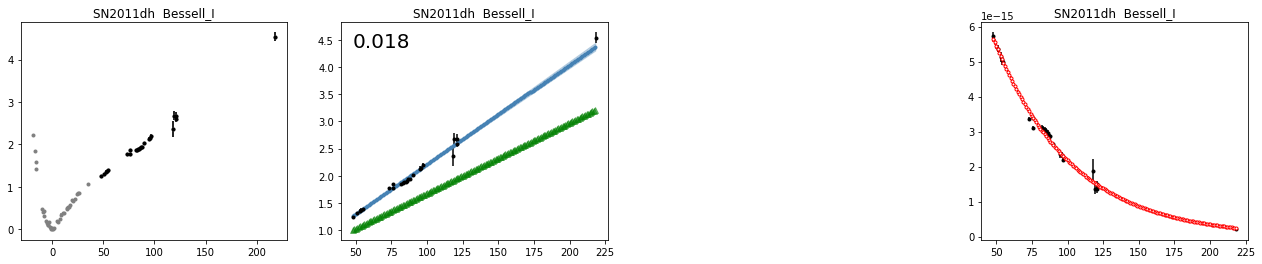

Bessell_V
Bessell_V 289.08000000000175


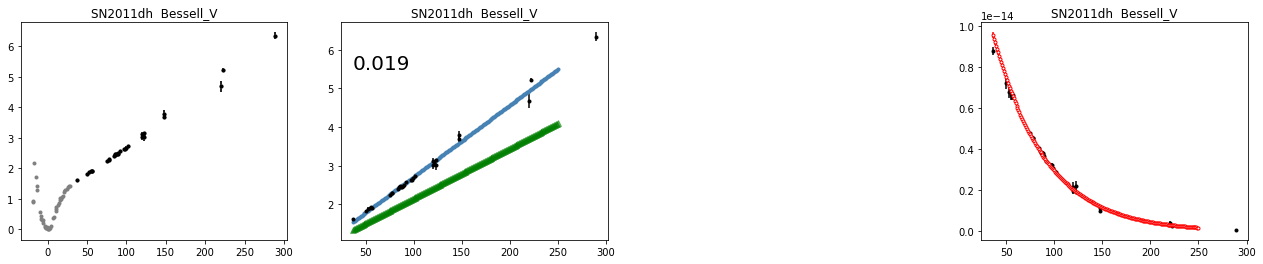

Bessell_B
Bessell_B 222.95000000000437
fix cobalt


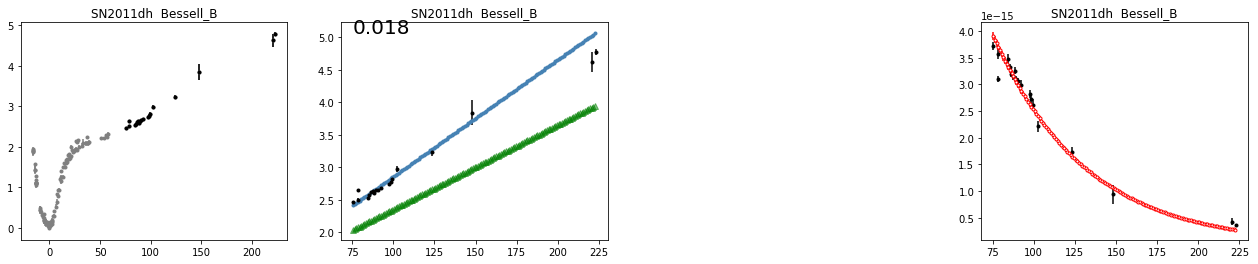

sdss_i'
sdss_i' 41.020000000004075
fix cobalt


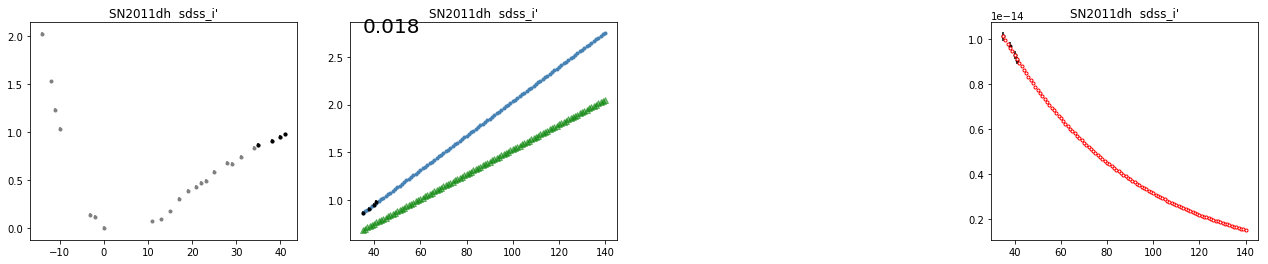

Bessell_R
Bessell_R 288.09999999999854


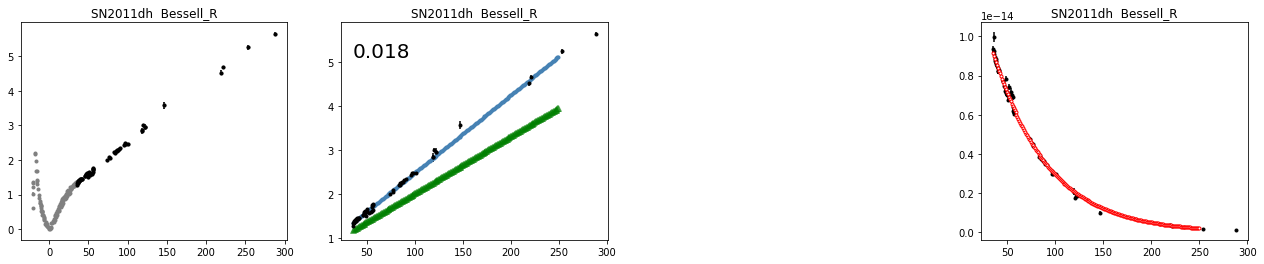

Bessell_U
Bessell_U 100.87999999999738
fix cobalt


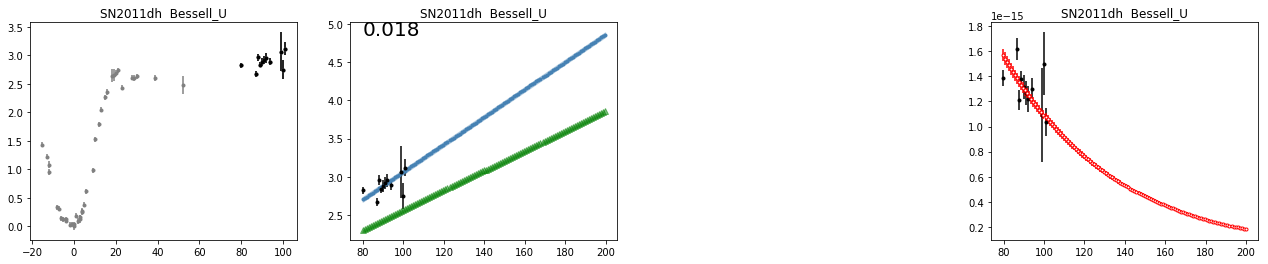

In [998]:
for sn in ['SN2011dh']:
    if sn in list(dict_phase_tail.keys()):
        prova2 = SNPhotometryClass(main_path=DATAMAIN_PATH, lc_path= DATALC_PATH,snname=sn, verbose=True)
        prova2.load()
        prova2.get_availfilter()
        prova2.clip_photometry()
        df = prova2.create_extended_LC()
        df.to_csv(prova2.sn_rawphot_file.replace('/Final_LC_NOMW_dust_corr/','/Final_LC_NOMW_sudopts/'), na_rep='nan',
              index=False, sep='\t', header=['#MJD','band','Flux','Flux_err','FilterSet','Source'])
    else:
        file = DATALC_PATH+sn+'.dat'
        shutil.copy2(file, file.replace('/Final_LC_NOMW_dust_corr/','/Final_LC_NOMW_sudopts/'))
        print ('copied', file.replace('/Final_LC_NOMW_dust_corr/','/Final_LC_NOMW_sudopts/'))


In [971]:
prova2 = SNPhotometryClass(main_path=DATAMAIN_PATH, lc_path= DATALC_PATH,snname='SN2004gv', verbose=True)
prova2.load()
prova2.get_availfilter()
prova2.clip_photometry()
prova2.get_availfilter()

Looking for Photometry for SN2004gv in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2004gv.dat
Got it!
Photometry loaded
Bessell_B Before clipping 18, after 18
Bessell_V Before clipping 18, after 18
sdss_g Before clipping 18, after 18
sdss_i Before clipping 17, after 17
sdss_r Before clipping 18, after 18
sdss_u Before clipping 13, after 13


array(['Bessell_B', 'Bessell_V', 'sdss_g', 'sdss_i', 'sdss_r', 'sdss_u'],
      dtype='<U9')

Bessell_B 53356.14
Bessell_V 53356.14
sdss_g 53356.14
sdss_i 53356.14
sdss_r 53356.14
sdss_u 53356.14


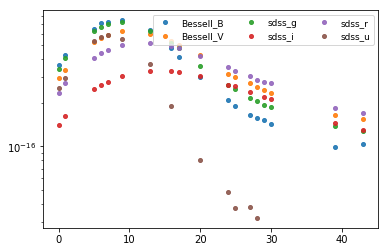

In [969]:
for ff in np.unique(prova2.clipped_phot['filter'])[:]:
    msk=prova2.clipped_phot['filter']==ff
    print (ff, min(prova2.clipped_phot['MJD'][msk]))
    plt.plot(prova2.clipped_phot['MJD'][msk]-min(prova2.clipped_phot['MJD']),
             prova2.clipped_phot['flux'][msk], 'o', ms=4, alpha=0.9, label=ff)
plt.legend(ncol=3, fontsize=9, loc='upper right')
plt.yscale('log')
#plt.xlim(-1,20)

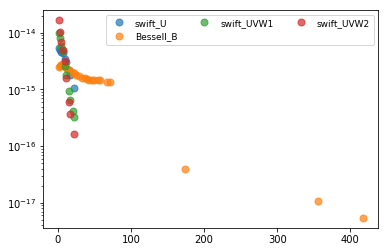

In [916]:
for ff in ['swift_U', 'Bessell_B', 'swift_UVW1','swift_UVW2']:#np.unique(prova2.clipped_phot['filter'])[4:]:
    msk=prova2.clipped_phot['filter']==ff
    plt.plot(prova2.clipped_phot['MJD'][msk]-min(prova2.clipped_phot['MJD']),
             prova2.clipped_phot['flux'][msk], 'o', ms=7, alpha=0.7, label=ff)
plt.legend(ncol=3, fontsize=9)
plt.yscale('log')
#plt.xlim(-1,20)
#plt.ylim(6*10**-15, 10**-14)

In [ ]:
for ff in ['swift_UVW1', 'swift_UVW2']:
    msk=prova2.clipped_phot['filter']==ff
    plt.plot(prova2.clipped_phot['MJD'][msk]-min(prova2.clipped_phot['MJD']),
             prova2.clipped_phot['flux'][msk], 'o', ms=7, alpha=0.7, label=ff)
plt.legend(ncol=3, fontsize=9)
plt.yscale('log')


In [ ]:
df = prova2.create_extended_LC()
df.to_csv(prova2.sn_rawphot_file.replace('/Final_LC_NOMW/','/Final_LC_NOMW_sudopts/'),na_rep='nan',
      index=False, sep='\t', header=['#MJD','band','Flux','Flux_err','FilterSet','Source'])

In [ ]:
prova2 = SNPhotometryClass(main_path=DATAMAIN_PATH, lc_path= DATALC_PATH,snname='SN2011dh', verbose=True)
prova2.load()
prova2.get_availfilter()
prova2.clip_photometry()

LC_filt_extended = prova2.get_singlefilter("swift_U", extended_clipped=True)

mjd_unsorted = LC_filt_extended['MJD']
mjd = np.sort(mjd_unsorted)
orig_flux = LC_filt_extended['flux'][np.argsort(mjd_unsorted)]
orig_flux_err = LC_filt_extended['flux_err'][np.argsort(mjd_unsorted)]

# prepare data to feed the GP
## norm time
offset_time = mjd[np.argmax(orig_flux)]
t = mjd - offset_time
## norm flux
max_fl = max(orig_flux)
logf = -np.log(orig_flux/max_fl)
logferr = orig_flux_err/orig_flux

### linear regression to guess the slope

mask_lenght = 25#dict_Phase_Decay[prova2.snname]
mask_tail = t>mask_lenght
t_lr = t[mask_tail]
logf_lr = logf[mask_tail]
logferr_lr = logferr[mask_tail]
w_lr = 1./logferr_lr**2

plt.errorbar(t, logf, yerr=logferr, marker='.', 
             mfc='grey', mec='grey', color='grey', linestyle='None')

plt.errorbar(t_lr, logf_lr, yerr=logferr_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')



In [ ]:
new_t = np.arange(min(t_lr), max(t_lr)+50 ,3)

plt.errorbar(t, logf, yerr=logferr,marker='.', 
             mfc='grey', mec='grey', color='grey', linestyle='None')

plt.errorbar(t_lr, logf_lr, yerr=logferr_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')

qq, mm, sigma_qq, sigma_mm = lin_regr_weigthed(t_lr, logf_lr,w_lr)

plt.plot(new_t, mm*(new_t)+qq, '--', color="#4682b4", alpha=1)
plt.plot(new_t, mm_cob56*(new_t)+qq, '^', color="g", alpha=1)

plt.xlabel('MJD')
plt.ylabel('LOG Flux')
plt.show()

plt.errorbar(t_lr, logf_lr-mm_cob56*t_lr, yerr=logferr_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')


if mm<mm_cob56:
    avg, inv_err = np.average(logf_lr-mm_cob56*t_lr, weights=1/(logferr_lr**2), returned=True)
    #std_qq = np.sqrt(1./inv_err)
    sigma_qq = np.std(logf_lr-mm_cob56*t_lr)
    plt.hlines(avg, min(t_lr), max(t_lr), 'r')
    plt.fill_between(new_t,  avg-sigma_qq,
                  avg+sigma_qq, color="r", alpha=0.2)
    plt.show()
    mm=mm_cob56
    qq= avg


fsub_lr = np.exp(-(logf_lr)) - np.exp(-(t_lr*mm+qq))
ferrsub_lr = np.copy(orig_flux_err[mask_tail])/max(orig_flux)

fig = plt.figure(1, figsize=(20,3))
plt.errorbar(t_lr, fsub_lr, yerr=ferrsub_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')
plt.hlines(0, min(t_lr), max(t_lr), 'r')

plt.fill_between(new_t,  - err_prop_func(new_t),
                  + err_prop_func(new_t), color="r", alpha=0.2)
plt.xlabel('MJD')
plt.ylabel('LOG Flux - LINEAR REGRESSION')

plt.xlim(min(t_lr)-1, max(t_lr)+1)
plt.show()

plt.errorbar(t_lr, logf_lr, yerr=logferr_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')
plt.xlabel('MJD')
plt.ylabel('LOG Flux')


plt.plot(new_t, mm*(new_t)+qq, '.', color="#4682b4", alpha=1)
err_prop_func = lambda x: ( (x*sigma_mm)**2 + sigma_qq**2 )**0.5

plt.fill_between(new_t, mm*(new_t)+qq - err_prop_func(new_t),
                  mm*(new_t)+qq + err_prop_func(new_t), color="#4682b4", alpha=0.3)
plt.plot(new_t, mm_cob56*(new_t)+qq, '^', color="g", alpha=1)

plt.show()
#

fit = max_fl * np.exp(-(new_t*mm+qq))
fit_err = np.abs(fit * err_prop_func(new_t))

#plt.errorbar(t, orig_flux, yerr=orig_flux_err, marker='.', 
#             mfc='grey', mec='grey', color='grey', linestyle='None')

plt.errorbar(t_lr, orig_flux[mask_tail], yerr=orig_flux_err[mask_tail], marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')

plt.errorbar(new_t, fit, yerr=fit_err, marker='.', 
             mfc='white', mec='r', color='r', linestyle='None')
plt.xlabel('MJD')
plt.ylabel('Flux')


plt.show()

plt.errorbar(t, orig_flux, yerr=orig_flux_err, marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')

plt.errorbar(new_t, fit, yerr=fit_err, marker='.', 
             mfc='white', mec='r', color='r', linestyle='None')
plt.xlabel('MJD')
plt.ylabel('Flux')


plt.show()



In [ ]:
gp_sub = george.GP(np.var(fsub_lr)*Matern32Kernel(20.))
gp_sub.compute(t_lr, ferrsub_lr)

def ll(p):
    gp_sub.set_parameter_vector(p)
    return -gp_sub.lnlikelihood(fsub_lr, quiet=False)#
def grad_ll(p):
    gp_sub.set_parameter_vector(p)
    return -gp_sub.grad_lnlikelihood(fsub_lr, quiet=False)
        
p0=gp_sub.get_parameter_vector()
results = opt.minimize(ll, p0, jac=grad_ll)

mu,cov = gp_sub.predict(fsub_lr, new_t, return_cov=True)
std = np.sqrt(np.diag(cov))

plt.errorbar(t_lr, fsub_lr, yerr=ferrsub_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')

plt.plot(new_t, mu, color="#4682b4", alpha=1)
plt.fill_between(new_t, mu-std, mu+std, color="#4682b4", alpha=0.3)


In [ ]:
plt.errorbar(t_lr, orig_flux[mask_tail], yerr=orig_flux_err[mask_tail], marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')

fit = max_fl*(mu + np.exp(-(new_t*mm+qq)))
fit_err = std*max_fl
plt.plot(new_t, fit)
plt.fill_between(new_t, fit-fit_err, fit+fit_err, color="#4682b4", alpha=0.3)
plt.show()

plt.errorbar(t, orig_flux, yerr=orig_flux_err, marker='.', 
             mfc='grey', mec='grey', color='grey', linestyle='None')

plt.errorbar(t_lr, orig_flux[mask_tail], yerr=orig_flux_err[mask_tail], marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')
plt.errorbar(new_t, fit, yerr=fit_err,marker='.', 
             mfc='white', mec='k', color='k', linestyle='None')

# MJD, band, Flux, Flux_err, FilterSet Source
#extra_pts = 

In [ ]:
lc_file = pd.DataFrame(np.genfromtxt(prova2.sn_rawphot_file,names=True, dtype=None,encoding="utf-8"))
extr_pts_pd = pd.DataFrame().reindex_like(lc_file)[:0]
extr_pts_pd['MJD'] = new_t+offset_time
extr_pts_pd['band'] = np.full(len(new_t), fill_value=ff)
extr_pts_pd['Flux'] = fit
extr_pts_pd['Flux_err'] = fit_err
extr_pts_pd['FilterSet'] = np.full(len(new_t), fill_value='SUDO_PTS')
extr_pts_pd['Source'] = np.full(len(new_t), fill_value='SUDO_PTS')

In [ ]:
extr_pts_pd['MJD'] = new_t+offset_time
extr_pts_pd['band'] = np.full(len(new_t), fill_value=ff)
extr_pts_pd['Flux'] = fit
extr_pts_pd['Flux_err'] = fit_err
extr_pts_pd['FilterSet'] = np.full(len(new_t), fill_value='SUDO_PTS')
extr_pts_pd['Source'] = np.full(len(new_t), fill_value='SUDO_PTS')

In [ ]:

fig=plt.figure(figsize=(5,5))
tt=np.arange(0,350,10)
plt.plot(tt, -tt*mm_cob56+18)
plt.xlim(0,350)
plt.ylim(20,9)

In [38]:
sn_list = [f.replace('.dat','') for f in os.listdir(DATALC_PATH) if '.dat' in f]

In [999]:
for sn in ['SN2011dh']:
    lc_file = pd.DataFrame(np.genfromtxt(os.path.join('/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_sudopts/', '%s.dat'%sn),
                               names=['MJD','band','Flux','Flux_err','FilterSet', 'Source'], 
                               usecols=[0,1,2,3,4,5], 
                               dtype=None,encoding="utf-8"))
    late_time_extension = lc_file[lc_file['Source'].values=='SUDO_PTS']
    lc_file = pd.DataFrame(np.genfromtxt(os.path.join('/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_early_extrapolation/', '%s.dat'%sn),
                               names=['MJD','band','Flux','Flux_err','FilterSet', 'Source'], 
                               usecols=[0,1,2,3,4,5], 
                               dtype=None,encoding="utf-8"))
    fully_ext_LC = pd.concat([lc_file, late_time_extension])
    fully_ext_LC.index = np.arange(0,len(fully_ext_LC),1)    

    fully_ext_LC.to_csv('/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_FULLY_EXTENDED/'+'%s.dat'%sn, na_rep='nan',
              index=False, sep='\t', header=['#MJD','band','Flux','Flux_err','FilterSet','Source'])
    print (sn)


SN2011dh
